In [1]:
from tqdm import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt

import vae
import data

In [2]:
# Creates shape random shape data.
shape_data = data.Generator(1000).generate_shapes()

# Creates PyTorch dataset.
dataset = vae.ShapeData(shape_data)

# Build VAE Model.
model = vae.VAE(2)

# Initialises model trainer.
trainer = vae.Trainer(dataset,model,lr=1e-3,batch_size=128,loss='mse')
trainer.train_model(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12669.89it/s]


RuntimeError: stack expects each tensor to be equal size, but got [200] at entry 0 and [100] at entry 1

In [20]:
test_shapes = data.Generator(5).generate_shapes()

100%|██████████| 5/5 [00:00<00:00, 2551.28it/s]


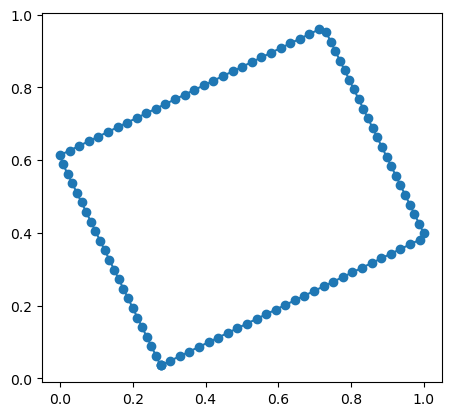

In [14]:
test_shapes[0].plot()

In [21]:
dt = [torch.tensor(shape.points, dtype=torch.float32).view(-1) for shape in test_shapes]

In [22]:
x = model.encoder(dt[0])  # Encoder block.
mu,logvar = model.fc_mu(x),model.fc_logvar(x)  # Mu & Logvar for latent layer.
z = model.reparameterise(mu,logvar)  # Obtain latent variables.
print(z)  # Z is differet each time due to the random sampling of epsilon.

tensor([ 0.4245, -0.1780], grad_fn=<AddBackward0>)


In [23]:
model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=128, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=200, bias=True)
  )
)

(100, 2)


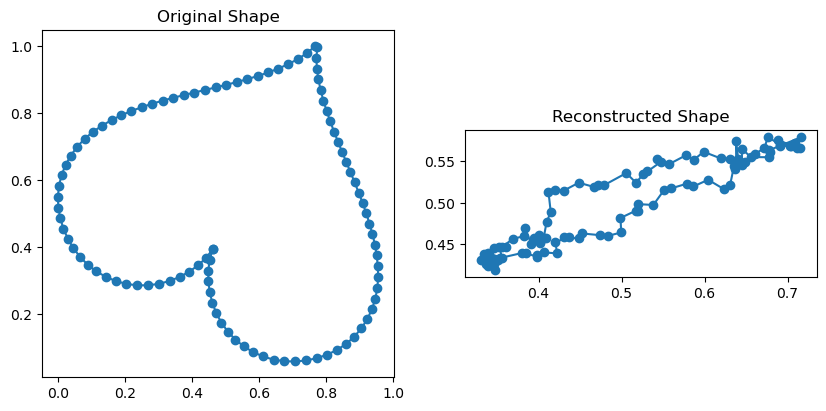

(100, 2)


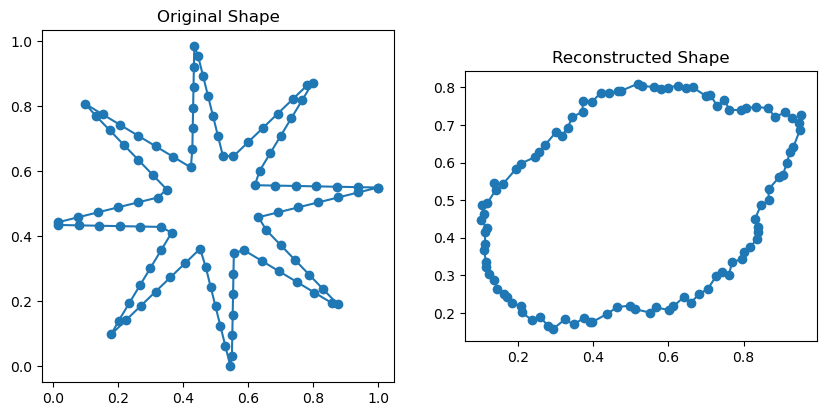

(100, 2)


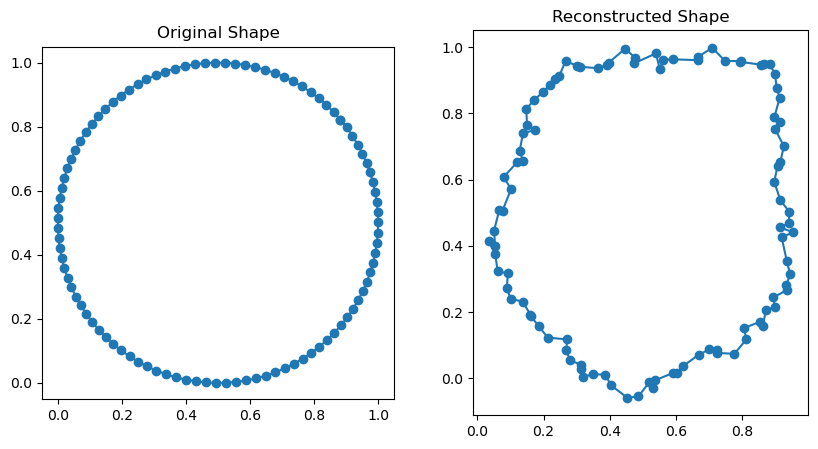

(100, 2)


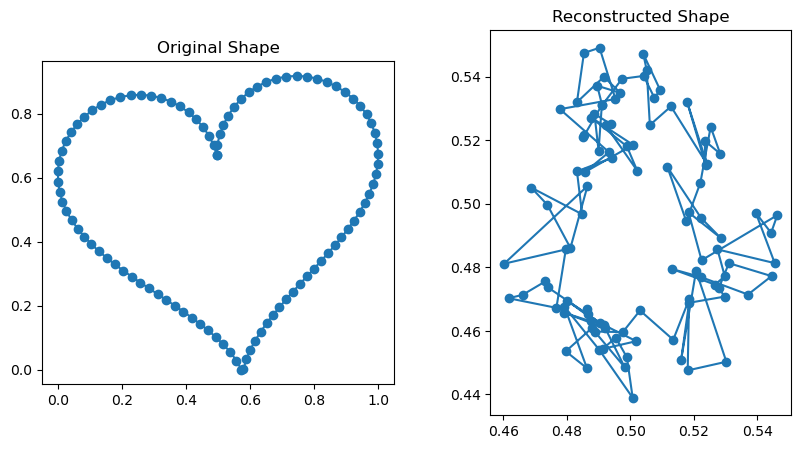

(100, 2)


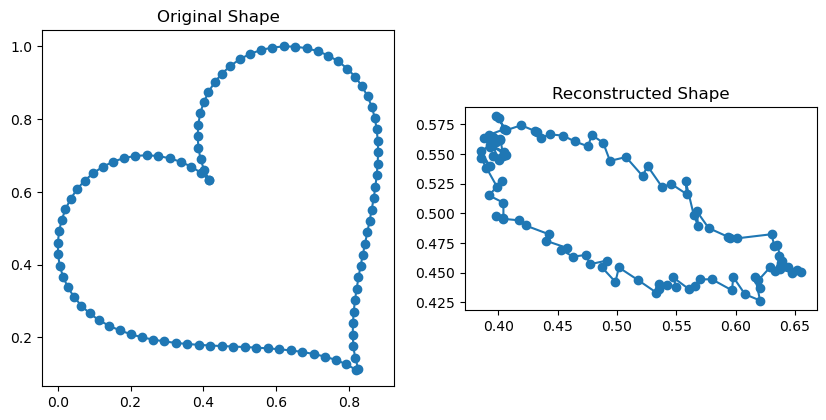

In [24]:
# Pass through VAE
with torch.no_grad():
    for shape in dt:
        recon_shape, mu, log_var = model(shape)
        recon_shape = recon_shape.squeeze(0).numpy().reshape(-1,2)

        orig_shape = shape.squeeze(0).numpy().reshape(-1,2)
        print(orig_shape.shape)
        # Plot Original vs. Reconstructed
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].plot(orig_shape[:, 0], orig_shape[:, 1], 'o-', label="Original")
        axs[0].set_title("Original Shape")
        axs[0].set_aspect('equal')

        axs[1].plot(recon_shape[:, 0], recon_shape[:, 1], 'o-', label="Reconstructed")
        axs[1].set_title("Reconstructed Shape")
        axs[1].set_aspect('equal')

        plt.show()


In [28]:
# Convert back to NumPy for visualization
test_shape = dt[0].squeeze(0).numpy()
recon_shape = recon_shape.squeeze(0).numpy()

In [20]:
# Reshape back to 2D (assuming (x,y) pairs)
test_shape_2d = test_shape[:200].reshape(-1, 2)
recon_shape_2d = recon_shape[:200].reshape(-1, 2)

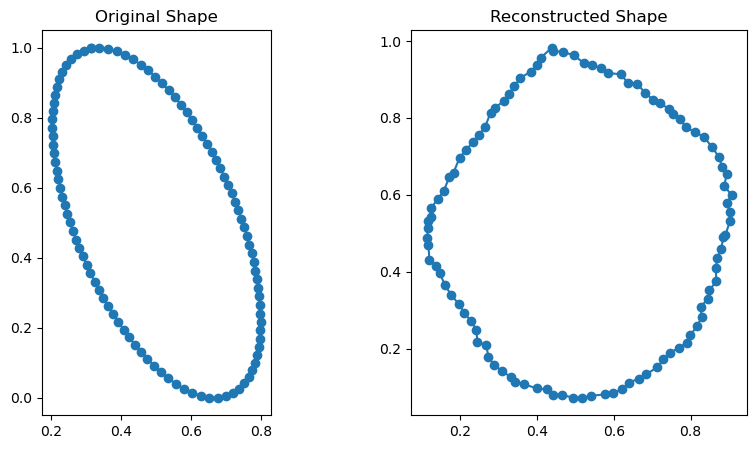

In [21]:
# Plot Original vs. Reconstructed
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(test_shape_2d[:, 0], test_shape_2d[:, 1], 'o-', label="Original")
axs[0].set_title("Original Shape")
axs[0].set_aspect('equal')

axs[1].plot(recon_shape_2d[:, 0], recon_shape_2d[:, 1], 'o-', label="Reconstructed")
axs[1].set_title("Reconstructed Shape")
axs[1].set_aspect('equal')

plt.show()